做未来做预测

现在比较流行的方式是预测股价，我觉得不是很靠谱。

## 我想到的一个是找最低点。
这样的话，问题就由一个回归问题变为一个分类问题。  
如以过去N天的(股价，成交量，时间（季度、月份），其它股票、指数、汇率、油价，等等)组成一个特征序列，来预测次日的股价是否是最低点。
最低点的判断依据：未来T天的股价收盘价均不小于预测序列最后一日的收盘价，且未来T天的收盘价最高点大于预测序列最后一日的收盘价的Z%

In [136]:
import pandas as pd
import numpy as np
import tushare as ts
from datetime import datetime, timedelta
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.models import load_model
import time

In [308]:
class tt:
    def __init__(self):
        ts.set_token('5fd1639100f8a22b7f86e882e03192009faa72bae1ae93803e1172d5')
        self._pro = ts.pro_api()
        
    def index_daily(self, ts_code, start_date, end_date):
        '''
        获取行情数据
        由于ts的接口一次只能获取1800个交易日（一年大概有250个交易日。约7年）的数据
        '''
        startdate = datetime.strptime(start_date, '%Y%m%d')
        enddate = datetime.strptime(end_date, '%Y%m%d')
        df = pd.DataFrame()
        while enddate.year-startdate.year>6:      
            print(startdate.strftime('%Y%m%d'), (startdate.replace(year=(startdate.year+6))-timedelta(days=1)).strftime('%Y%m%d'))
            t = self._pro.index_daily(ts_code=ts_code, start_date=startdate.strftime('%Y%m%d'), end_date=(startdate.replace(year=(startdate.year+6))-timedelta(days=1)).strftime('%Y%m%d'))
            if not df.empty:
                df = pd.concat([df,t], axis=0)
            else:
                df = t
            startdate = startdate.replace(year=(startdate.year+6))
        else:
            print(startdate.strftime('%Y%m%d'),end_date)
            t = self._pro.index_daily(ts_code=ts_code, start_date=startdate.strftime('%Y%m%d'), end_date=end_date)
            if not df.empty:
                df = pd.concat([df,t], axis=0)
            else:
                df = t
        return df.sort_values('trade_date')
    def normlize_field(self, df, fieldnamelist):
        '''
        #设df中某一字段 第一日净值为1
        '''
        df1 = pd.DataFrame()
        df1['ts_code'] = df['ts_code']
        df1['trade_date'] = df['trade_date']
        for f in fieldnamelist:
            df1[f+'_1'] = df.apply(lambda x: x[f]/df.iloc[0][f], axis=1)        
        return df1
    def build_flag(self, df,series_len,pro_len, fieldnamelist):
        '''
        构建训练集

        series_len: 参考的之前的序列范围。如以之前的series_len个序列预测下一个序列，则series_len=series_len
        pro_len: 预测日以后的天数（含预测日）
        '''
        r = list()
        l1 = list(df['close_1'])
        for i in range(series_len,(df.shape[0]-pro_len)):
            final_list = list()
            laa = l1[i:i+pro_len]
            #最低点和买点的关系：最低点一定是买点，买点不一定是最低点
            #买点特征
            #买点日之后14日最高收盘价涨幅超过0.05，最低价不得低于买点日收盘价
            #最低点的特征：在买点特征的基础上
            #最低日收盘价低于前一日收盘价

            f1 = 0 # 买点标志 1表示买点
            f2 = 0 # 最低点标志 1表示最低点
            if (max(laa) - l1[i])/l1[i] > 0.05 and min(laa[1:]) > l1[i]:#未来pro_len日最高收盘价涨幅超过0.05
                f1 = 1
                if l1[i] < l1[i-1]:
                    f2 = 1
            final_list.append(df[fieldnamelist].values[(i-series_len) : i])
            final_list.append(f1)
            final_list.append(f2)
            r.append(final_list)    
        return r
    def getNum(self, ll):
        '''
        获取买点、最低点的个数
        '''
        y = [(i[-2],i[-1]) for i in ll]
        return Counter(y)
    def preprocess(self,ll,balance=True):
        '''
        数据预处理，获得可用于训练的set
        '''
        ll1 = [i for i in ll if i[1]==1]#买点数据
        #均衡数据
        ll2 = ll
        if balance:
            ll2 += ll1* (round(len(ll)/len(ll1))-1)
        ll3 = [(i[1],i[2]) for i in ll2]
        x = np.array([i[0] for i in ll2])
        y1 = np.array([[i[1]] for i in ll2])#买点
        y2 = np.array([[i[2]] for i in ll2])#最低点
        print(Counter(ll3))
        return x,np_utils.to_categorical(y1,num_classes=2),np_utils.to_categorical(y2,num_classes=2)
    def splitData(self,x,y):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
        return x_train, x_test, y_train, y_test
    def buildModel(self, n):
        '''
        # 创建模型
        n 考虑的特征的个数
        '''
        model = Sequential()

        # 循环神经网络
        model.add(LSTM(
            units = 256, # 输出
            input_shape = (180,n), #输入
        ))
        model.add(Dense(200,activation='tanh'))
        # 输出层
        model.add(Dense(2,activation='softmax'))

        # 定义优化器
        adam = Adam(lr=1e-4)

        # 定义优化器，loss function，训练过程中计算准确率
        model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
        print(model.summary())
        self._model = model
    def train(self,x_train,y_train,batch_size=128,epochs=300):
        # 训练模型
        start = time.time()
        self._model.fit(x_train,y_train,batch_size,epochs)
        print('@ Total Time Spent: %.2f seconds' % (time.time() - start))
    def evaluate(self,x_test,y_test):
        # 评估模型
        loss,accuracy = t._model.evaluate(x_test,y_test)
        print('test loss',loss)
        print('test accuracy',accuracy)
        return loss,accuracy
    def build_x(self, df,series_len, start):
        '''
        构建预测序列

        series_len: 参考的之前的序列范围。如以之前的series_len个序列预测下一个序列，则series_len=series_len
        '''
        ll = list()
        l1 = list(df['close_1'])
        l4 = list(df['vol_1'])
        l5 = list(df['amount_1'])
        for i in range(df.shape[0]-start,df.shape[0]):
            final_list = list()
            l2 = l1[i-series_len : i]
            ll.append(list(zip(l1[i-series_len : i],l4[i-series_len : i],l5[i-series_len : i])))    
        return ll
    def predict(self, x_list):
        '''
        x_list: 预测序列的list
        '''
        r = self._model.predict(x_list)
        return r
    def loadModel(self, filepath):
        self._model = load_model(filepath)
    def evaluateScore(self, y_test, y_predict):
        score = accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_predict,axis=1))
        c  = classification_report(np.argmax(y_test,axis=1), np.argmax(y_predict,axis=1))
        print(score)
        print(c)

In [309]:
t = tt()

In [62]:
df = t.index_daily('000001.SH',start_date='20010101', end_date='20181130')

20010101 20061231
20070101 20121231
20130101 20181130


In [63]:
df

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount
1443,000001.SH,20010102,2103.4690,2077.0760,2103.5380,2074.8820,2073.4770,29.9920,1.4465,18650746.0,1.340509e+07
1442,000001.SH,20010103,2123.8990,2108.2540,2123.9000,2105.4970,2103.4690,20.4300,0.9713,17157673.0,1.751683e+07
1441,000001.SH,20010104,2117.4050,2125.4850,2127.4190,2113.1790,2123.8990,-6.4940,-0.3058,13423541.0,1.429525e+07
1440,000001.SH,20010105,2125.3000,2117.6640,2125.3810,2114.0560,2117.4050,7.8950,0.3729,13288175.0,1.484424e+07
1439,000001.SH,20010108,2102.0640,2128.6020,2131.9800,2092.0970,2125.3000,-23.2360,-1.0933,14787085.0,1.588766e+07
1438,000001.SH,20010109,2101.1350,2099.3230,2111.1000,2082.8410,2102.0640,-0.9290,-0.0442,11649338.0,1.158177e+07
1437,000001.SH,20010110,2125.6150,2102.0850,2125.6700,2102.0660,2101.1350,24.4800,1.1651,12916883.0,1.302625e+07
1436,000001.SH,20010111,2119.1410,2129.6100,2131.3680,2117.0290,2125.6150,-6.4740,-0.3046,14072209.0,1.461571e+07
1435,000001.SH,20010112,2104.7470,2116.8460,2117.7270,2100.2730,2119.1410,-14.3940,-0.6792,10660882.0,1.101729e+07
1434,000001.SH,20010115,2032.4430,2097.0910,2097.0920,2030.2880,2104.7470,-72.3040,-3.4353,14998588.0,1.341256e+07


### 考察变量之间的相关性
可以看出，'close', 'open', 'high', 'low', 'pre_close'是高度相关的，选择close；  
'change', 'pct_chg'是高度相关的，选择'pct_chg'，日涨幅  
'vol', 'amount'是高度相关的，选择'amount' 成交额  

In [227]:
df[['close', 'open', 'high', 'low', 'pre_close','change', 'pct_chg', 'vol', 'amount']].corr()

,close,open,high,low,pre_close,change,pct_chg,vol,amount
close,1.000000,0.998944,0.999453,0.999478,0.998696,0.025162,0.025756,0.589149,0.638105
open,0.998944,1.000000,0.999616,0.999420,0.999753,-0.016207,-0.013193,0.586728,0.636472
high,0.999453,0.999616,1.000000,0.999223,0.999468,-0.000677,0.002667,0.590316,0.639420
low,0.999478,0.999420,0.999223,1.000000,0.999147,0.006110,0.007001,0.585492,0.634642
pre_close,0.998696,0.999753,0.999468,0.999147,1.000000,-0.025914,-0.021918,0.586968,0.636394
change,0.025162,-0.016207,-0.000677,0.006110,-0.025914,1.000000,0.933392,0.042483,0.033257
pct_chg,0.025756,-0.013193,0.002667,0.007001,-0.021918,0.933392,1.000000,0.048877,0.036247
vol,0.589149,0.586728,0.590316,0.585492,0.586968,0.042483,0.048877,1.000000,0.974351
amount,0.638105,0.636472,0.639420,0.634642,0.636394,0.033257,0.036247,0.974351,1.000000


In [225]:
df.columns

Index(['ts_code', 'trade_date', 'close', 'open', 'high', 'low', 'pre_close',
       'change', 'pct_chg', 'vol', 'amount'],
      dtype='object')

#### 剔除掉相关性大的变量

In [310]:
df1 = df[['ts_code', 'trade_date', 'close','pct_chg', 'amount']]
df1.head()

,ts_code,trade_date,close,pct_chg,amount
1443,000001.SH,20010102,2103.469,1.4465,1.340509e+07
1442,000001.SH,20010103,2123.899,0.9713,1.751683e+07
1441,000001.SH,20010104,2117.405,-0.3058,1.429525e+07
1440,000001.SH,20010105,2125.300,0.3729,1.484424e+07
1439,000001.SH,20010108,2102.064,-1.0933,1.588766e+07


## 考察变量的分布

In [230]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4343 entries, 1443 to 0
Data columns (total 5 columns):
ts_code       4343 non-null object
trade_date    4343 non-null object
close         4343 non-null float64
pct_chg       4343 non-null float64
amount        4343 non-null float64
dtypes: float64(3), object(2)
memory usage: 203.6+ KB


In [231]:
import matplotlib.pyplot as plt

{'whiskers': [<matplotlib.lines.Line2D at 0x7fca68754358>,
 'caps': [<matplotlib.lines.Line2D at 0x7fca68754c18>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fca68754208>],
 'medians': [<matplotlib.lines.Line2D at 0x7fca6875d4a8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fca6875d8d0>],
 'means': []}

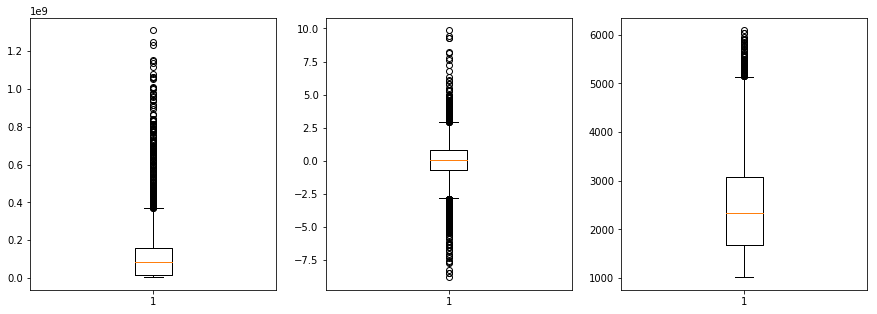

In [239]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.boxplot(df1['amount'])
plt.subplot(132)
plt.boxplot(df1['pct_chg'])
plt.subplot(133)
plt.boxplot(df1['close'])

In [282]:
# def normalize(df, fieldlist):
#     for f in fieldlist:
#         a = df[f].max()
#         b = df[f].min()
#         print(f,a,b)
#         if f == 'pct_chg':
#             df[f] = df.apply(lambda x:(x[f]-b)/(a-b),axis=1)
#         else:
#             df[f] = df.apply(lambda x:x[f]/(a-b),axis=1)

# normalize(df1,['close','pct_chg', 'amount'])

In [313]:
df1 = t.normlize_field(df1,['{}'.format(i) for i in ['close','pct_chg', 'amount']])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fca60137978>,
 'caps': [<matplotlib.lines.Line2D at 0x7fca600c1278>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fca60137828>],
 'medians': [<matplotlib.lines.Line2D at 0x7fca600c1ac8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fca600c1ef0>],
 'means': []}

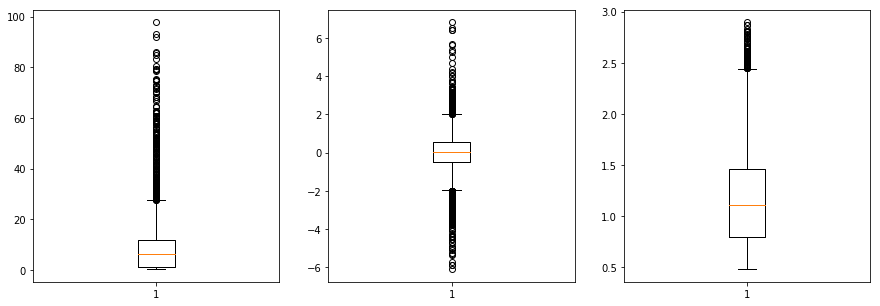

In [314]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.boxplot(df1['amount_1'])
plt.subplot(132)
plt.boxplot(df1['pct_chg_1'])
plt.subplot(133)
plt.boxplot(df1['close_1'])

In [273]:
df1.head()

,ts_code,trade_date,close,pct_chg,amount
1443,000001.SH,20010102,0.214931,0.550183,0.008220
1442,000001.SH,20010103,0.218952,0.524768,0.011365
1441,000001.SH,20010104,0.217674,0.456465,0.008901
1440,000001.SH,20010105,0.219228,0.492764,0.009321
1439,000001.SH,20010108,0.214655,0.414347,0.010119


In [316]:
fieldlist = ['close_1','pct_chg_1', 'amount_1']
ll = t.build_flag(df1,180,15,fieldlist)

In [317]:
ll[0]

[array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
        [ 1.00971253e+00,  6.71482890e-01,  1.30672949e+00],
        [ 1.00662525e+00, -2.11406844e-01,  1.06640391e+00],
        [ 1.01037857e+00,  2.57794677e-01,  1.10735780e+00],
        [ 9.99332056e-01, -7.55824404e-01,  1.18519578e+00],
        [ 9.98890404e-01, -3.05565157e-02,  8.63982455e-01],
        [ 1.01052832e+00,  8.05461459e-01,  9.71739006e-01],
        [ 1.00745055e+00, -2.10577255e-01,  1.09031034e+00],
        [ 1.00060757e+00, -4.69547183e-01,  8.21873292e-01],
        [ 9.66233874e-01, -2.37490494e+00,  1.00055684e+00],
        [ 9.72625221e-01,  4.57310750e-01,  7.76265367e-01],
        [ 9.67251716e-01, -3.81956447e-01,  4.93057008e-01],
        [ 9.71305020e-01,  2.89733840e-01,  6.25255774e-01],
        [ 9.81999735e-01,  7.61216730e-01,  6.41665224e-01],
        [ 9.54628758e-01, -1.92692707e+00,  5.52050888e-01],
        [ 9.48583031e-01, -4.37815417e-01,  5.94875479e-01],
        [ 9.41273202e-01

In [259]:
y = [(i[-2],i[-1]) for i in ll]

In [260]:
Counter(y)

Counter({(0, 0): 3662, (1, 1): 217, (1, 0): 269})

In [318]:
df2 = df1.iloc[180:(df1.shape[0]-15)]
df2['y1'] = [i[0] for i in y]
df2['y2'] = [i[1] for i in y]

/home/ian/installed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ian/installed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [319]:
df2

,ts_code,trade_date,close_1,pct_chg_1,amount_1,y1,y2
1263,000001.SH,20011009,0.829411,0.724991,0.235083,0,0
1262,000001.SH,20011010,0.801824,-2.299412,0.348804,0,0
1261,000001.SH,20011011,0.778869,-1.979191,0.368340,0,0
1260,000001.SH,20011012,0.804065,2.236433,0.605245,0,0
1259,000001.SH,20011015,0.802142,-0.165365,0.384142,0,0
1258,000001.SH,20011016,0.787224,-1.285655,0.281191,0,0
1257,000001.SH,20011017,0.781122,-0.535914,0.229858,0,0
1256,000001.SH,20011018,0.768055,-1.156516,0.263443,0,0
1255,000001.SH,20011019,0.747552,-1.845420,0.459681,0,0
1254,000001.SH,20011022,0.722934,-2.276668,0.319451,1,1


## 数据预处理

#### 由于数据不均衡，买点的数据很少。买点数据:非买点数据≈1:7.所以，额外复制6份买点数据，使得数据均衡

In [320]:
x,y1,y2 = t.preprocess(ll[:-250])

Counter({(0, 0): 3424, (1, 0): 2096, (1, 1): 1696})


In [321]:
x_train, x_test, y_train, y_test = t.splitData(x,y1)

In [322]:
len(x_train),len(x_test)

(5051, 2165)

In [176]:
# # 打乱数据
# np.random.seed(14)
# shuffle_indices = np.random.permutation(np.arange(len(y1)))
# x_shuffled = x[shuffle_indices]
# y1_shuffled = y1[shuffle_indices]
# y2_shuffled = y2[shuffle_indices]

# # x1 = x.reshape(x.shape[0],-1)
# x_train, x_test = x_shuffled[:3000], x_shuffled[3000:]

# y11 = np_utils.to_categorical(y1_shuffled,num_classes=2)
# y_train, y_test = y11[:3000], y11[3000:]

# a = [y_train[i,1] for i in range(y_train.shape[0])]
# Counter(a)

In [323]:
model = t.buildModel(len(fieldlist))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 256)               266240    
_________________________________________________________________
dense_23 (Dense)             (None, 200)               51400     
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 402       
Total params: 318,042
Trainable params: 318,042
Non-trainable params: 0
_________________________________________________________________
None


In [324]:
t.train(x_train, y_train, epochs=150)

Epoch 1/150
5051/5051 [==============================] - 27s 5ms/step - loss: 0.6998 - acc: 0.5165
Epoch 2/150
5051/5051 [==============================] - 24s 5ms/step - loss: 0.6854 - acc: 0.5524
Epoch 3/150
5051/5051 [==============================] - 25s 5ms/step - loss: 0.6813 - acc: 0.5714
Epoch 4/150
5051/5051 [==============================] - 25s 5ms/step - loss: 0.6693 - acc: 0.5872
Epoch 5/150
5051/5051 [==============================] - 24s 5ms/step - loss: 0.6513 - acc: 0.6038
Epoch 6/150
5051/5051 [==============================] - 23s 5ms/step - loss: 0.6494 - acc: 0.5973
Epoch 7/150
5051/5051 [==============================] - 25s 5ms/step - loss: 0.6427 - acc: 0.6221
Epoch 8/150
5051/5051 [==============================] - 24s 5ms/step - loss: 0.6471 - acc: 0.6120
Epoch 9/150
5051/5051 [==============================] - 25s 5ms/step - loss: 0.6296 - acc: 0.6185
Epoch 10/150
5051/5051 [==============================] - 25s 5ms/step - loss: 0.6196 - acc: 0.6349
Epoch 11/

5051/5051 [==============================] - 25s 5ms/step - loss: 0.3807 - acc: 0.8115
Epoch 84/150
5051/5051 [==============================] - 25s 5ms/step - loss: 0.3630 - acc: 0.8226
Epoch 85/150
5051/5051 [==============================] - 26s 5ms/step - loss: 0.3593 - acc: 0.8289
Epoch 86/150
5051/5051 [==============================] - 26s 5ms/step - loss: 0.3507 - acc: 0.8299
Epoch 87/150
5051/5051 [==============================] - 25s 5ms/step - loss: 0.3500 - acc: 0.8363
Epoch 88/150
5051/5051 [==============================] - 26s 5ms/step - loss: 0.3503 - acc: 0.8262
Epoch 89/150
5051/5051 [==============================] - 25s 5ms/step - loss: 0.3516 - acc: 0.8270
Epoch 90/150
5051/5051 [==============================] - 25s 5ms/step - loss: 0.3522 - acc: 0.8287
Epoch 91/150
5051/5051 [==============================] - 25s 5ms/step - loss: 0.3431 - acc: 0.8371
Epoch 92/150
5051/5051 [==============================] - 25s 5ms/step - loss: 0.3422 - acc: 0.8353
Epoch 93/150


In [350]:
t.train(x_train, y_train, epochs=50)

Epoch 1/50
5051/5051 [==============================] - 24s 5ms/step - loss: 0.2610 - acc: 0.8873
Epoch 2/50
5051/5051 [==============================] - 25s 5ms/step - loss: 0.2482 - acc: 0.9004
Epoch 3/50
5051/5051 [==============================] - 26s 5ms/step - loss: 0.2518 - acc: 0.8927
Epoch 4/50
5051/5051 [==============================] - 25s 5ms/step - loss: 0.2657 - acc: 0.8881
Epoch 5/50
5051/5051 [==============================] - 26s 5ms/step - loss: 0.2651 - acc: 0.8862
Epoch 6/50
5051/5051 [==============================] - 25s 5ms/step - loss: 0.2601 - acc: 0.8911
Epoch 7/50
5051/5051 [==============================] - 24s 5ms/step - loss: 0.2530 - acc: 0.8986
Epoch 8/50
5051/5051 [==============================] - 25s 5ms/step - loss: 0.2446 - acc: 0.9024
Epoch 9/50
5051/5051 [==============================] - 25s 5ms/step - loss: 0.2425 - acc: 0.8994
Epoch 10/50
5051/5051 [==============================] - 24s 5ms/step - loss: 0.2371 - acc: 0.9054
Epoch 11/50
5051/50

In [360]:
t.train(x_train, y_train, epochs=50)

Epoch 1/50
5051/5051 [==============================] - 23s 5ms/step - loss: 0.2256 - acc: 0.9121
Epoch 2/50
5051/5051 [==============================] - 25s 5ms/step - loss: 0.2239 - acc: 0.9123
Epoch 3/50
5051/5051 [==============================] - 24s 5ms/step - loss: 0.2295 - acc: 0.9093
Epoch 4/50
5051/5051 [==============================] - 24s 5ms/step - loss: 0.2261 - acc: 0.9107
Epoch 5/50
5051/5051 [==============================] - 26s 5ms/step - loss: 0.2184 - acc: 0.9159
Epoch 6/50
5051/5051 [==============================] - 25s 5ms/step - loss: 0.2250 - acc: 0.9125
Epoch 7/50
5051/5051 [==============================] - 24s 5ms/step - loss: 0.2169 - acc: 0.9168
Epoch 8/50
5051/5051 [==============================] - 25s 5ms/step - loss: 0.2175 - acc: 0.9192
Epoch 9/50
5051/5051 [==============================] - 25s 5ms/step - loss: 0.2221 - acc: 0.9121
Epoch 10/50
5051/5051 [==============================] - 25s 5ms/step - loss: 0.2146 - acc: 0.9161
Epoch 11/50
5051/50

In [372]:
t.train(x_train, y_train, epochs=20)

Epoch 1/20
5051/5051 [==============================] - 25s 5ms/step - loss: 0.2041 - acc: 0.9246
Epoch 2/20
5051/5051 [==============================] - 25s 5ms/step - loss: 0.1928 - acc: 0.9264
Epoch 3/20
5051/5051 [==============================] - 25s 5ms/step - loss: 0.1830 - acc: 0.9337
Epoch 4/20
5051/5051 [==============================] - 25s 5ms/step - loss: 0.2755 - acc: 0.8955
Epoch 5/20
5051/5051 [==============================] - 25s 5ms/step - loss: 0.2353 - acc: 0.9091
Epoch 6/20
5051/5051 [==============================] - 25s 5ms/step - loss: 0.2034 - acc: 0.9212
Epoch 7/20
5051/5051 [==============================] - 25s 5ms/step - loss: 0.1997 - acc: 0.9242
Epoch 8/20
5051/5051 [==============================] - 25s 5ms/step - loss: 0.1967 - acc: 0.9236
Epoch 9/20
5051/5051 [==============================] - 25s 5ms/step - loss: 0.1920 - acc: 0.9271
Epoch 10/20
5051/5051 [==============================] - 25s 5ms/step - loss: 0.1858 - acc: 0.9285
Epoch 11/20
5051/50

In [373]:
# 评估模型
loss,accuracy = t._model.evaluate(x_test,y_test)

print('test loss',loss)
print('test accuracy',accuracy)

2165/2165 [==============================] - 6s 3ms/step
test loss 0.2525109618076276
test accuracy 0.9066974596118266


In [374]:
x_p,y1_p,y2_p = t.preprocess(ll[-250:],balance=False)

Counter({(0, 0): 238, (1, 0): 7, (1, 1): 5})


In [363]:
# t._model.save('model1201_2.h5')#只考虑2个特征

# t.loadModel('model1201_2.h5')

In [375]:
y_predict = t.predict(x_p)

In [328]:
# y_predict.shape


(250, 2)

In [376]:
t.evaluateScore(y1_p, y_predict)

0.852
             precision    recall  f1-score   support

          0       0.95      0.89      0.92       238
          1       0.04      0.08      0.05        12

avg / total       0.91      0.85      0.88       250



In [210]:
Counter(np.argmax(y_predict,axis=1))

Counter({0: 225, 1: 25})

效果不理想。缩减到

In [330]:
from pyecharts import Line

In [377]:
dft = df2.iloc[-250:]

In [378]:
dft['y1_predict'] = np.argmax(y_predict,axis=1)

/home/ian/installed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [344]:
dft

,ts_code,trade_date,close_1,pct_chg_1,amount_1,y1,y2,y1_predict
264,000001.SH,20171102,1.608443,-0.256550,15.666802,0,0,0
263,000001.SH,20171103,1.602945,-0.236295,15.474560,0,0,0
262,000001.SH,20171106,1.610755,0.336882,15.241312,0,0,0
261,000001.SH,20171107,1.622831,0.518286,18.097295,0,0,0
260,000001.SH,20171108,1.623727,0.038161,18.054747,0,0,0
259,000001.SH,20171109,1.629591,0.249637,15.325044,0,0,0
258,000001.SH,20171110,1.631910,0.098375,19.080217,0,0,0
257,000001.SH,20171113,1.639119,0.305358,19.898265,0,0,0
256,000001.SH,20171114,1.630425,-0.366678,19.950282,0,0,0
255,000001.SH,20171115,1.617578,-0.544763,17.883812,0,0,0


In [334]:
# dft = df2.iloc[-250:][df2.iloc[-250:]['y1']==1]

In [379]:
gg = [{'coord':[line[2], line[3]]} for line in dft[dft['y1']==1].itertuples()]

In [380]:
line = Line("000001.SH可视化观察",title_pos='center',subtitle="真实值")
line.add(
    '上涨指数收盘价',
    df2.iloc[-250:,1],df2.iloc[-250:,2],
    legend_top='bottom',
    is_more_utils=True,
    mark_point=gg,
    mark_point_symbolsize=80
)

In [381]:
gg1 = [{'coord':[line[2], line[3]]} for line in dft[dft['y1_predict']==1].itertuples()]

In [382]:
line = Line("000001.SH可视化观察",title_pos='center',subtitle="预测值")
line.add(
    'sepal length (cm)',
    df2.iloc[-250:,1],df2.iloc[-250:,2],
    legend_top='bottom',
    is_more_utils=True,
    mark_point=gg1,
    mark_point_symbolsize=80
)

## 利用BP做预测

In [82]:
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [144]:
np.array([[i[1]] for i in ll])

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [157]:
# 创建模型，输入784个神经元，输出10个神经元
model = Sequential()
model.add(Dense(units=100,input_dim=90,bias_initializer='one',activation='tanh'))
model.add(Dense(units=500,bias_initializer='one',activation='tanh'))
model.add(Dense(units=500,bias_initializer='one',activation='tanh'))
model.add(Dense(units=2,activation='tanh'))

# 定义优化器
sgd = SGD(lr=0.2)

# 定义优化器，loss function，训练过程中计算准确率
model.compile(
    optimizer = sgd,
    loss = 'mse',
    metrics=['accuracy'],
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 100)               9100      
_________________________________________________________________
dense_29 (Dense)             (None, 500)               50500     
_________________________________________________________________
dense_30 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 1002      
Total params: 311,102
Trainable params: 311,102
Non-trainable params: 0
_________________________________________________________________


In [158]:
# 训练模型
model.fit(x_train,y_train,batch_size=128,epochs=100)

# 评估模型
loss,accuracy = model.evaluate(x_test,y_test)

print('\ntest loss',loss)
print('accuracy',accuracy)

Epoch 1/100
3200/3200 [==============================] - 0s 132us/step - loss: 0.5184 - acc: 0.8687
Epoch 2/100
3200/3200 [==============================] - 0s 49us/step - loss: 0.5000 - acc: 0.8687
Epoch 3/100
3200/3200 [==============================] - 0s 46us/step - loss: 0.5000 - acc: 0.8687
Epoch 4/100
3200/3200 [==============================] - 0s 48us/step - loss: 0.5000 - acc: 0.8687
Epoch 5/100
3200/3200 [==============================] - 0s 40us/step - loss: 0.5000 - acc: 0.8687
Epoch 6/100
3200/3200 [==============================] - 0s 47us/step - loss: 0.5000 - acc: 0.8687
Epoch 7/100
3200/3200 [==============================] - 0s 47us/step - loss: 0.5000 - acc: 0.8687
Epoch 8/100
3200/3200 [==============================] - 0s 48us/step - loss: 0.5000 - acc: 0.8687
Epoch 9/100
3200/3200 [==============================] - 0s 49us/step - loss: 0.5000 - acc: 0.8687
Epoch 10/100
3200/3200 [==============================] - 0s 48us/step - loss: 0.5000 - acc: 0.8687
Epoch 11

3200/3200 [==============================] - 0s 47us/step - loss: 0.5000 - acc: 0.8687
Epoch 84/100
3200/3200 [==============================] - 0s 51us/step - loss: 0.5000 - acc: 0.8687
Epoch 85/100
3200/3200 [==============================] - 0s 48us/step - loss: 0.5000 - acc: 0.8687
Epoch 86/100
3200/3200 [==============================] - 0s 46us/step - loss: 0.5000 - acc: 0.8687
Epoch 87/100
3200/3200 [==============================] - 0s 46us/step - loss: 0.5000 - acc: 0.8687
Epoch 88/100
3200/3200 [==============================] - 0s 48us/step - loss: 0.5000 - acc: 0.8687
Epoch 89/100
3200/3200 [==============================] - 0s 43us/step - loss: 0.5000 - acc: 0.8687
Epoch 90/100
3200/3200 [==============================] - 0s 44us/step - loss: 0.5000 - acc: 0.8687
Epoch 91/100
3200/3200 [==============================] - 0s 47us/step - loss: 0.5000 - acc: 0.8687
Epoch 92/100
3200/3200 [==============================] - 0s 49us/step - loss: 0.5000 - acc: 0.8687
Epoch 93/100


## 使用CNN

In [28]:
from keras.layers import Dense,Dropout,Convolution2D,MaxPooling2D,Flatten
from keras.optimizers import Adam
import time

In [29]:
# 定义顺序模型
model = Sequential()

# 第一个卷积层
# input_shape 输入平面
# filters 卷积核/滤波器个数
# kernel_size 卷积窗口大小
# strides 步长
# padding padding方式 same/valid
# activation 激活函数
model.add(Convolution2D(
    input_shape = (10,9,1),
    filters = 64,
    kernel_size = 5,
    strides = 1,
    padding = 'same',
    activation = 'relu'
))
# 第一个池化层
model.add(MaxPooling2D(
    pool_size = 2,
    strides = 2,
    padding = 'same',
))
# 第二个卷积层
model.add(Convolution2D(126,5,strides=1,padding='same',activation = 'relu'))
# 第二个池化层
model.add(MaxPooling2D(2,2,'same'))

# 第三个卷积层
model.add(Convolution2D(256,5,strides=1,padding='same',activation = 'relu'))
# 第三个池化层
model.add(MaxPooling2D(2,2,'same'))

# 把第三个池化层的输出扁平化为1维
model.add(Flatten())
# 第一个全连接层
model.add(Dense(1024,activation = 'relu'))
# Dropout
model.add(Dropout(0.5))
# 第二个全连接层
model.add(Dense(2,activation='softmax'))

# 定义优化器
adam = Adam(lr=1e-4)

# 定义优化器，loss function，训练过程中计算准确率
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 10, 9, 64)         1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 126)         201726    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 126)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 256)         806656    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
__________

In [30]:
start = time.time()
# 训练模型
model.fit(x_train.reshape((x_train.shape[0],10,9,1)),y_train,batch_size=256,epochs=266)
print('@ Total Time Spent: %.2f seconds' % (time.time() - start))

Epoch 1/266
3200/3200 [==============================] - 2s 739us/step - loss: 0.5231 - acc: 0.8419
Epoch 2/266
3200/3200 [==============================] - 2s 534us/step - loss: 0.4764 - acc: 0.8687
Epoch 3/266
3200/3200 [==============================] - 2s 588us/step - loss: 0.4567 - acc: 0.8687
Epoch 4/266
3200/3200 [==============================] - 2s 545us/step - loss: 0.4319 - acc: 0.8694
Epoch 5/266
3200/3200 [==============================] - 2s 539us/step - loss: 0.4317 - acc: 0.8663
Epoch 6/266
3200/3200 [==============================] - 2s 545us/step - loss: 0.4137 - acc: 0.8684
Epoch 7/266
3200/3200 [==============================] - 2s 529us/step - loss: 0.4128 - acc: 0.8675
Epoch 8/266
3200/3200 [==============================] - 2s 522us/step - loss: 0.4165 - acc: 0.8678
Epoch 9/266
3200/3200 [==============================] - 2s 543us/step - loss: 0.4117 - acc: 0.8669
Epoch 10/266
3200/3200 [==============================] - 2s 527us/step - loss: 0.4056 - acc: 0.8687

3200/3200 [==============================] - 2s 544us/step - loss: 0.0197 - acc: 0.9969
Epoch 163/266
3200/3200 [==============================] - 2s 544us/step - loss: 0.0221 - acc: 0.9966
Epoch 164/266
3200/3200 [==============================] - 2s 540us/step - loss: 0.0205 - acc: 0.9966
Epoch 165/266
3200/3200 [==============================] - 2s 544us/step - loss: 0.0184 - acc: 0.9972
Epoch 166/266
3200/3200 [==============================] - 2s 547us/step - loss: 0.0168 - acc: 0.9969
Epoch 167/266
3200/3200 [==============================] - 2s 527us/step - loss: 0.0171 - acc: 0.9975
Epoch 168/266
3200/3200 [==============================] - 2s 514us/step - loss: 0.0161 - acc: 0.9981
Epoch 169/266
3200/3200 [==============================] - 2s 533us/step - loss: 0.0163 - acc: 0.9969
Epoch 170/266
3200/3200 [==============================] - 2s 555us/step - loss: 0.0162 - acc: 0.9975
Epoch 171/266
3200/3200 [==============================] - 2s 525us/step - loss: 0.0161 - acc: 0

In [31]:
p = model.predict(x_test.reshape((x_test.shape[0],10,9,1)))

In [32]:
p[-10:]

array([[9.9998593e-01, 1.4124693e-05],
       [1.0000000e+00, 4.3917570e-10],
       [1.0000000e+00, 8.7278396e-10],
       [9.9999309e-01, 6.8770369e-06],
       [9.9999988e-01, 7.6666971e-08],
       [1.0000000e+00, 5.8134241e-08],
       [9.9999738e-01, 2.6630350e-06],
       [9.9998093e-01, 1.9049217e-05],
       [1.0000000e+00, 2.8458558e-08],
       [9.9926537e-01, 7.3465967e-04]], dtype=float32)

In [33]:
model.evaluate(x_test.reshape((x_test.shape[0],10,9,1)),y_test)

355/355 [==============================] - 0s 386us/step


[0.582860738884114, 0.9492957746478873]

In [168]:
y1[-10:]

array([[0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

## 使用SimpleRNN预测

In [34]:
from keras.layers.recurrent import SimpleRNN

In [36]:
# 创建模型
model = Sequential()

# 循环神经网络
model.add(SimpleRNN(
    units = 50, # 输出
    input_shape = (30,3), #输入
))

# 输出层
model.add(Dense(2,activation='softmax'))

# 定义优化器
adam = Adam(lr=1e-4)

# 定义优化器，loss function，训练过程中计算准确率
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 50)                2700      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 2,802
Trainable params: 2,802
Non-trainable params: 0
_________________________________________________________________


In [38]:
# 训练模型
model.fit(x[:3200],y_train[:3200],batch_size=64,epochs=10)

Epoch 1/10
3200/3200 [==============================] - 1s 263us/step - loss: 0.4818 - acc: 0.8672
Epoch 2/10
3200/3200 [==============================] - 1s 175us/step - loss: 0.4001 - acc: 0.8688
Epoch 3/10
3200/3200 [==============================] - 1s 178us/step - loss: 0.3906 - acc: 0.8688
Epoch 4/10
3200/3200 [==============================] - 1s 174us/step - loss: 0.3893 - acc: 0.8688
Epoch 5/10
3200/3200 [==============================] - 1s 173us/step - loss: 0.3888 - acc: 0.8688
Epoch 6/10
3200/3200 [==============================] - 1s 176us/step - loss: 0.3884 - acc: 0.8688
Epoch 7/10
3200/3200 [==============================] - 1s 164us/step - loss: 0.3878 - acc: 0.8688
Epoch 8/10
3200/3200 [==============================] - 1s 183us/step - loss: 0.3874 - acc: 0.8688
Epoch 9/10
3200/3200 [==============================] - 1s 176us/step - loss: 0.3869 - acc: 0.8688
Epoch 10/10
3200/3200 [==============================] - 1s 175us/step - loss: 0.3864 - acc: 0.8688


In [41]:
# 训练模型
model.fit(x[:3200],y_train[:3200],batch_size=64,epochs=200)

Epoch 1/200
3200/3200 [==============================] - 0s 150us/step - loss: 0.3267 - acc: 0.8759
Epoch 2/200
3200/3200 [==============================] - 0s 155us/step - loss: 0.3344 - acc: 0.8709
Epoch 3/200
3200/3200 [==============================] - 1s 176us/step - loss: 0.3281 - acc: 0.8744
Epoch 4/200
3200/3200 [==============================] - 1s 163us/step - loss: 0.3265 - acc: 0.8744
Epoch 5/200
3200/3200 [==============================] - 1s 161us/step - loss: 0.3263 - acc: 0.8747
Epoch 6/200
3200/3200 [==============================] - 1s 171us/step - loss: 0.3314 - acc: 0.8728
Epoch 7/200
3200/3200 [==============================] - 0s 151us/step - loss: 0.3254 - acc: 0.8769
Epoch 8/200
3200/3200 [==============================] - 1s 168us/step - loss: 0.3251 - acc: 0.8759
Epoch 9/200
3200/3200 [==============================] - 1s 169us/step - loss: 0.3254 - acc: 0.8769
Epoch 10/200
3200/3200 [==============================] - 1s 180us/step - loss: 0.3298 - acc: 0.8762

3200/3200 [==============================] - 0s 153us/step - loss: 0.3223 - acc: 0.8803
Epoch 163/200
3200/3200 [==============================] - 1s 170us/step - loss: 0.3325 - acc: 0.8694
Epoch 164/200
3200/3200 [==============================] - 1s 158us/step - loss: 0.3228 - acc: 0.8778
Epoch 165/200
3200/3200 [==============================] - 0s 146us/step - loss: 0.3192 - acc: 0.8787
Epoch 166/200
3200/3200 [==============================] - 1s 191us/step - loss: 0.3177 - acc: 0.8784
Epoch 167/200
3200/3200 [==============================] - 1s 167us/step - loss: 0.3185 - acc: 0.8781
Epoch 168/200
3200/3200 [==============================] - 0s 154us/step - loss: 0.3177 - acc: 0.8791
Epoch 169/200
3200/3200 [==============================] - 1s 157us/step - loss: 0.3210 - acc: 0.8791
Epoch 170/200
3200/3200 [==============================] - 0s 155us/step - loss: 0.3232 - acc: 0.8778
Epoch 171/200
3200/3200 [==============================] - 1s 161us/step - loss: 0.3222 - acc: 0

In [42]:
# 评估模型
loss,accuracy = model.evaluate(x[3200:],y_test)

print('test loss',loss)
print('test accuracy',accuracy)

p = model.predict(x[3200:])

p[-10:]

355/355 [==============================] - 0s 337us/step
test loss 0.2047892114226247
test accuracy 0.9183098591549296


## LSTM

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 256)               266240    
_________________________________________________________________
dense_15 (Dense)             (None, 200)               51400     
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 402       
Total params: 318,042
Trainable params: 318,042
Non-trainable params: 0
_________________________________________________________________


In [183]:
# 训练模型
model.fit(x_train,y_train,batch_size=128,epochs=300)

Epoch 1/300
3000/3000 [==============================] - 16s 5ms/step - loss: 0.6923 - acc: 0.5437
Epoch 2/300
3000/3000 [==============================] - 15s 5ms/step - loss: 0.6766 - acc: 0.5727
Epoch 3/300
3000/3000 [==============================] - 16s 5ms/step - loss: 0.6729 - acc: 0.5717
Epoch 4/300
3000/3000 [==============================] - 15s 5ms/step - loss: 0.6595 - acc: 0.5937
Epoch 5/300
3000/3000 [==============================] - 15s 5ms/step - loss: 0.6479 - acc: 0.6037
Epoch 6/300
3000/3000 [==============================] - 15s 5ms/step - loss: 0.6299 - acc: 0.6253
Epoch 7/300
3000/3000 [==============================] - 15s 5ms/step - loss: 0.6149 - acc: 0.6533
Epoch 8/300
3000/3000 [==============================] - 15s 5ms/step - loss: 0.6237 - acc: 0.6487
Epoch 9/300
3000/3000 [==============================] - 15s 5ms/step - loss: 0.6083 - acc: 0.6653
Epoch 10/300
3000/3000 [==============================] - 16s 5ms/step - loss: 0.6081 - acc: 0.6547
Epoch 11/

3000/3000 [==============================] - 15s 5ms/step - loss: 0.6706 - acc: 0.6453
Epoch 84/300
3000/3000 [==============================] - 16s 5ms/step - loss: 0.5949 - acc: 0.6760
Epoch 85/300
3000/3000 [==============================] - 16s 5ms/step - loss: 0.5712 - acc: 0.6920
Epoch 86/300
3000/3000 [==============================] - 16s 5ms/step - loss: 0.5663 - acc: 0.7057
Epoch 87/300
3000/3000 [==============================] - 16s 5ms/step - loss: 0.5418 - acc: 0.7163
Epoch 88/300
3000/3000 [==============================] - 16s 5ms/step - loss: 0.5287 - acc: 0.7193
Epoch 89/300
3000/3000 [==============================] - 15s 5ms/step - loss: 0.5016 - acc: 0.7397
Epoch 90/300
3000/3000 [==============================] - 16s 5ms/step - loss: 0.5086 - acc: 0.7370
Epoch 91/300
3000/3000 [==============================] - 16s 5ms/step - loss: 0.5028 - acc: 0.7410
Epoch 92/300
3000/3000 [==============================] - 16s 5ms/step - loss: 0.4885 - acc: 0.7540
Epoch 93/300


3000/3000 [==============================] - 15s 5ms/step - loss: 0.3455 - acc: 0.8470
Epoch 246/300
3000/3000 [==============================] - 15s 5ms/step - loss: 0.3411 - acc: 0.8463
Epoch 247/300
3000/3000 [==============================] - 15s 5ms/step - loss: 0.3282 - acc: 0.8520
Epoch 248/300
3000/3000 [==============================] - 16s 5ms/step - loss: 0.3169 - acc: 0.8653
Epoch 249/300
3000/3000 [==============================] - 15s 5ms/step - loss: 0.3125 - acc: 0.8640
Epoch 250/300
3000/3000 [==============================] - 16s 5ms/step - loss: 0.3159 - acc: 0.8563
Epoch 251/300
3000/3000 [==============================] - 16s 5ms/step - loss: 0.3225 - acc: 0.8553
Epoch 252/300
3000/3000 [==============================] - 15s 5ms/step - loss: 0.3220 - acc: 0.8670
Epoch 253/300
3000/3000 [==============================] - 15s 5ms/step - loss: 0.3162 - acc: 0.8600
Epoch 254/300
3000/3000 [==============================] - 16s 5ms/step - loss: 0.3053 - acc: 0.8660
Epoc

In [123]:
# 评估模型
loss,accuracy = model.evaluate(x_test,y_test)

print('test loss',loss)
print('test accuracy',accuracy)

2961/2961 [==============================] - 8s 3ms/step
test loss 0.30742023430817517
test accuracy 0.8571428572233768


In [124]:
p = model.predict(x[3000:])

p[-10:]

array([[0.0176864 , 0.9823136 ],
       [0.03465068, 0.9653494 ],
       [0.16076513, 0.83923495],
       [0.45331347, 0.54668653],
       [0.41238803, 0.5876119 ],
       [0.5698003 , 0.43019968],
       [0.61668897, 0.383311  ],
       [0.3237785 , 0.67622155],
       [0.46554664, 0.5344534 ],
       [0.5422835 , 0.45771652]], dtype=float32)

In [90]:
np.argmax(p, axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [128]:
np.argmax(y_test,axis=1)[-10:]

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 0])

In [133]:
np.argmax(model.predict(x_test[-10:]),axis=1)

array([0, 1, 0, 1, 1, 0, 1, 0, 1, 1])

In [126]:
y_test

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [134]:
x_test[-10:]

array([[[ 0.68243315,  0.58925604,  0.35573441],
        [ 0.68677302,  0.60780638,  0.37112146],
        [ 0.67700302,  0.59209266,  0.36469325],
        ...,
        [ 0.71984887,  1.20518682,  0.67997824],
        [ 0.70889313,  1.09930849,  0.61711824],
        [ 0.71217514,  0.85800405,  0.48673185]],

       [[ 1.6819057 ,  6.03897411,  7.58308694],
        [ 1.69757553,  6.65576341,  7.79173837],
        [ 1.70689292,  6.39256763,  7.62175808],
        ...,
        [ 1.79684022,  3.68024718,  5.08508901],
        [ 1.7982281 ,  3.47404753,  4.95274987],
        [ 1.77590998,  3.10637131,  4.34346348]],

       [[ 1.27212026,  3.65098843,  3.56377684],
        [ 1.26060288,  4.51145991,  4.53849977],
        [ 1.25757134,  3.793343  ,  3.64790272],
        ...,
        [ 1.86877036,  9.48100705, 13.10308744],
        [ 1.82473817,  6.47218655,  8.85794759],
        [ 1.88310358,  6.03973828,  8.25170571]],

       ...,

       [[ 1.63147805,  5.79491248,  7.16018928],
        [ 1

In [135]:
xx = np.array([i[0] for i in ll[-10:]])
np.argmax(model.predict(xx),axis=1)

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [154]:
np.array(abc)

array([[[ 1.95026352, 11.3495938 , 15.20362192],
        [ 1.92244136,  8.75392854, 11.44907751],
        [ 1.84453147, 11.15166778, 14.01059662],
        ...,
        [ 1.57083227,  8.42761109,  8.68090376],
        [ 1.56725252,  7.11881712,  7.14707477],
        [ 1.556636  ,  7.53343428,  7.58273817]],

       [[ 1.92244136,  8.75392854, 11.44907751],
        [ 1.84453147, 11.15166778, 14.01059662],
        [ 1.85883735,  6.66826689,  8.80521819],
        ...,
        [ 1.56725252,  7.11881712,  7.14707477],
        [ 1.556636  ,  7.53343428,  7.58273817],
        [ 1.55327102,  6.94335831,  6.62535627]],

       [[ 1.84453147, 11.15166778, 14.01059662],
        [ 1.85883735,  6.66826689,  8.80521819],
        [ 1.8770085 ,  6.59070499,  8.85887366],
        ...,
        [ 1.556636  ,  7.53343428,  7.58273817],
        [ 1.55327102,  6.94335831,  6.62535627],
        [ 1.53160664,  6.63066435,  6.24389029]],

       ...,

       [[ 1.91800832,  6.56171404,  9.19654414],
        [ 1

In [152]:
xx

array([[[ 2.09771845, 11.0022761 , 15.84030392],
        [ 2.09114247, 10.58728632, 14.82902633],
        [ 2.0969308 ,  9.68628021, 13.29251755],
        ...,
        [ 1.56461218,  9.21610509, 10.15978727],
        [ 1.52922219,  7.75706671,  8.59493856],
        [ 1.53421362,  6.96184024,  7.3160305 ]],

       [[ 2.09114247, 10.58728632, 14.82902633],
        [ 2.0969308 ,  9.68628021, 13.29251755],
        [ 2.07622857, 10.26601178, 14.69656275],
        ...,
        [ 1.52922219,  7.75706671,  8.59493856],
        [ 1.53421362,  6.96184024,  7.3160305 ],
        [ 1.53451088,  7.04763742,  7.08679076]],

       [[ 2.0969308 ,  9.68628021, 13.29251755],
        [ 2.07622857, 10.26601178, 14.69656275],
        [ 2.05560673,  8.10617701, 11.56920766],
        ...,
        [ 1.53421362,  6.96184024,  7.3160305 ],
        [ 1.53451088,  7.04763742,  7.08679076],
        [ 1.53159208,  6.91293925,  6.86976996]],

       ...,

       [[ 2.04032633,  9.05222006, 12.16635837],
        [ 2

In [185]:
np.argmax(model.predict(np.array(abc)),axis=1)

array([0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [191]:
np.argmax(model_all.predict(np.array(abc)),axis=1)

array([0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [156]:
from sklearn.metrics import accuracy_score, classification_report

In [160]:
score = accuracy_score(np.argmax(y_test,axis=1), np.argmax(model.predict(x_test),axis=1))

In [158]:
y_test

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [161]:
score

0.8571428571428571

In [164]:
c  = classification_report(np.argmax(y_test,axis=1), np.argmax(model.predict(x_test),axis=1))

In [165]:
print(c)

             precision    recall  f1-score   support

          0       0.85      0.85      0.85      1437
          1       0.86      0.86      0.86      1524

avg / total       0.86      0.86      0.86      2961



In [180]:
model.save('model_all1.h5')

In [190]:
model_all = load_model('model_all.h5')